In [1]:
import numpy as np # for numerical operations
import matplotlib.pyplot as plt # for visualization (plotting)
from math import exp
from urllib.request import urlretrieve
import pickle
import os
import struct

# to display plots inline (with the rest of the output) rather than in a separate window
%matplotlib inline

Classification with real data.

Loading images from pickle...
Loading labels from pickle...
done
(60000, 28, 28)
(60000,)
5


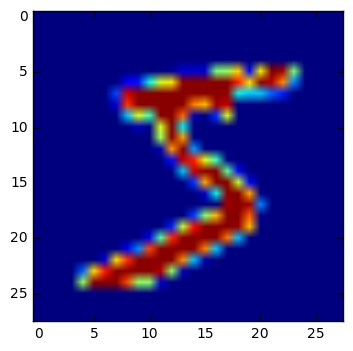

0


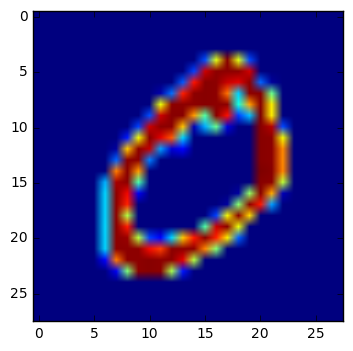

4


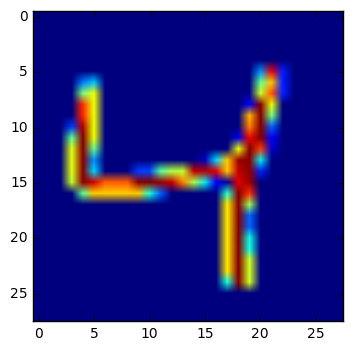

In [2]:
url_train_images = 'http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz'
url_train_labels = 'http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz'
filename_train_images = 'data/mnist_train_images'
filename_train_labels = 'data/mnist_train_labels'

def load_file(url, filename):
    if not os.path.isfile(filename):
        print('Loading file...')
        temp_filename, _ = urlretrieve(url)
        temp_file = gzip.open(temp_filename)
        file = open(filename, 'wb')
        file.write(temp_file.read())
        file.close()
        temp_file.close()
        
load_file(url_train_images, filename_train_images)
load_file(url_train_labels, filename_train_labels)

def getPickleFilename(filename):
    return filename + '.pickle'

def saveToPickle(data, filename):
    file = open(getPickleFilename(filename), 'wb')
    pickle.dump(data, file)
    file.close()
    
def loadFromPickle(filename):
    if not os.path.isfile(getPickleFilename(filename)):
        return np.array([])
    file = open(getPickleFilename(filename), 'rb')
    data = pickle.load(file)
    file.close()
    return data

def getImages(filename):
    print('Loading images from pickle...')
    images = loadFromPickle(filename)
    if not images.any():
        print('Pickle not found. Parsing images from file...')
        images = []
        f = open(filename, 'rb')
        magic_number = struct.unpack('>I',f.read(4))[0]
        num_images = struct.unpack('>I',f.read(4))[0]
        num_rows = struct.unpack('>I',f.read(4))[0]
        num_columns = struct.unpack('>I',f.read(4))[0]
        for i in range(0, num_images):
            image = []
            for j in range(0, num_rows):
                row = []
                for k in range(0, num_columns):
                    pixel = struct.unpack('B',f.read(1))[0]
                    row.append(pixel)
                image.append(row)
            images.append(image)
        f.close()
        print('Saving images to pickle...')
        saveToPickle(np.array(images), filename)
    return images

def getLabels(filename):
    print('Loading labels from pickle...')
    labels = loadFromPickle(filename)
    if not labels.any():
        print('Pickle not found. Parsing labels from file...')
        labels = []
        f = open(filename, 'rb')
        magic_number = struct.unpack('>I',f.read(4))[0]
        num_labels = struct.unpack('>I',f.read(4))[0]
        for i in range(0, num_labels):
            labels.append(struct.unpack('B',f.read(1))[0])
        f.close()
        print('Saving images to pickle...')
        saveToPickle(np.array(labels), filename)
    return labels
    
images = getImages(filename_train_images)
labels = getLabels(filename_train_labels)

print('done')
print(images.shape)
print(labels.shape)

for i in range(0, 3):
    print(labels[i])
    plt.imshow(images[i])
    plt.show()

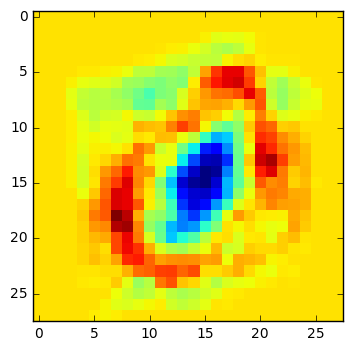

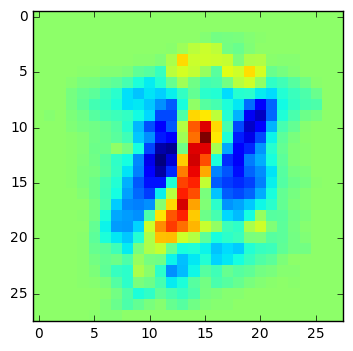

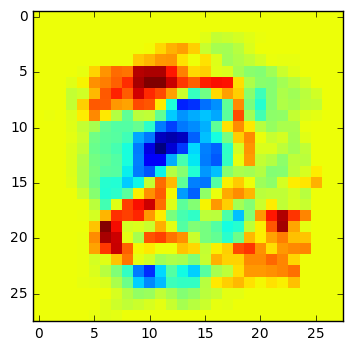

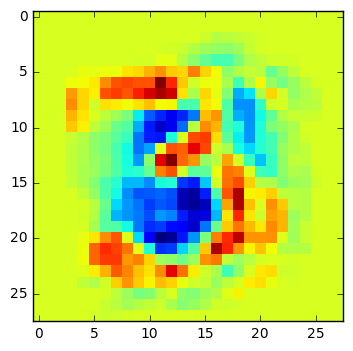

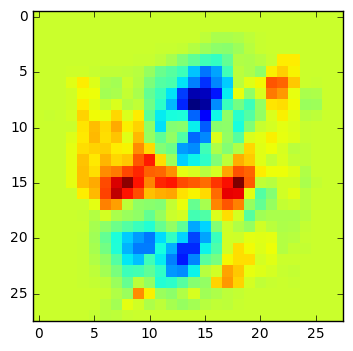

In [5]:
class Machine:
    def __init__(self, n):
        self.w = np.zeros(n)
    def h(self, x):
        return 1 / (1 + np.exp(-x.dot(self.w.T)))

def loss(x, y, m):
    return np.sum(-y * np.log(x) - (1 - y) * np.log(1 - x)) / m

def gradient_descent(machine, training_set, correct_values, alpha, iterations):
    m = training_set.shape[0]
    n = training_set.shape[1]
    values = []
    values.append(np.copy(machine.w))
    losses = []
    for i in range(0, iterations):
        d = (machine.h(training_set) - correct_values).dot(training_set)
        machine.w -= alpha * d / m
        values.append(np.copy(machine.w))
        losses.append(loss(machine.h(training_set), correct_values, m))
    #print(losses)
    #plt.plot(values)
    #plt.show()
    #plt.plot(losses)
    #plt.show()

def trainer(images, labels, alpha, iterations, m):
    n = 784
    # Take subset of m samples and flatten images (28 X 28 => 784)
    images = images[0:m].reshape(m,n)
    labels = labels[0:m]
    #print(labels.shape)
    
    # Add bias
    images = np.insert(images, 0, 1, axis=1)
    #print(images.shape)
    
    # Create labels for each class
    label_set = []
    machines = []
    classes = range(0, 10)
    for c in classes:
        label_set.append(np.zeros(m))
        machines.append(Machine(n + 1))     
    for i in range(0,m):
        label_set[labels[i]][i] = 1
        
    #print(labels)    
    #print(label_set)    

    for i in range(0, 5):
        gradient_descent(machines[i], images, label_set[i], alpha, iterations)
        #print(images[0])
        #print(machines[i].h(images[0:10]))
        weightImage = machines[i].w[1:].reshape(28,28)
        plt.figure()
        plt.imshow(weightImage, interpolation="nearest")
        #print(weightImage)
    
trainer(images, labels, alpha = 0.00001, iterations = 10, m = 100)

In [4]:
def predict(machines, image):
    number = -1;
    bestP = 0;
    for i in range(0, len(machines)):
        p = machines[i].h(image)
        if p > bestP:
            number = i
            bestP = p
        #print(i)
        #print(p)
    return (number, bestP)   

def trainer(images, labels, alpha, iterations, m):
    n = 784
    testImages = images[m:m+10].reshape(10,n)
    testImages = np.insert(testImages, 0, 1, axis=1)
    testLabels = labels[m:m+10]
    # Take subset of m samples and flatten images (28 X 28 => 784)
    images = images[0:m].reshape(m,n)
    labels = labels[0:m]
    
    # Add bias
    images = np.insert(images, 0, 1, axis=1)
    
    # Create labels for each class
    label_set = []
    machines = []
    classes = range(0, 10)
    for c in classes:
        label_set.append(np.zeros(m))
        machines.append(Machine(n + 1))     
    for i in range(0,m):
        label_set[labels[i]][i] = 1

    for i in range(0, 10):
        gradient_descent(machines[i], images, label_set[i], alpha, iterations)
    
    # First test with training data (this should be easy)
    print(labels[0:10])
    for image in images[0:10]:
        print(predict(machines, image))
    
    # Test with unseen data (this should be harder)
    print(testLabels)
    for image in testImages[0:10]:
        print(predict(machines, image))
    
trainer(images, labels, alpha = 0.00001, iterations = 100, m = 100)

[5 0 4 1 9 2 1 3 1 4]
(5, 0.87335117210839797)
(0, 0.9990007612882168)
(4, 0.99732923355618008)
(1, 0.97115505059786)
(9, 0.91205913949967121)
(2, 0.91316309680318208)
(1, 0.97195432481936561)
(3, 0.90484903361329483)
(1, 0.96206205970770253)
(4, 0.96328590803596981)
[5 7 1 7 1 1 6 3 0 2]
(8, 0.21742302952295572)
(7, 0.93290852861616713)
(1, 0.97438575569496944)
(7, 0.94331765810610269)
(1, 0.76764546829779268)
(1, 0.98659262702243322)
(6, 0.97989958078056139)
(3, 0.77220512036224032)
(0, 0.84226776423292915)
(6, 0.15114215922181085)


When testing with unseen data the algorithm fails predicting 5 and 2 and instead predicts 8 and 6 with probabilities 0.22 and 0.15 respectively. Otherwise it does quite well.